In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [2]:
# open glass dataset file
file = open('glass.txt', "r")

# read samples from dataset file
data = []

for f in file:
    x = f.split()
    s = x[0].split(',')
    s = [float(i) for i in s]
    data.append(s)

# converting data into dataframe
glass_df = pd.DataFrame(data, columns = ['0','1','2','3','4','5','6','7','8','9','class'])
del glass_df['0']   # as question wanted
glass_df = glass_df.astype({'class':'int'})
glass_df.head()

,1,2,3,4,5,6,7,8,9,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
# open tic-tac-toe dataset file
file = open('tic-tac-toe.txt', "r")

# read samples from dataset file
data = []

for f in file:
    x = f.split()
    x = [int(i) for i in x]
    data.append(x)

tic_tac_df = pd.DataFrame(data, columns = ['1','2','3','4','5','6','7','8','9','class'])
tic_tac_df.head()

,1,2,3,4,5,6,7,8,9,class
0,1,1,1,1,-1,-1,1,-1,-1,1
1,1,1,1,1,-1,-1,-1,1,-1,1
2,1,1,1,1,-1,-1,-1,-1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1
4,1,1,1,1,-1,-1,0,-1,0,1


# Split test/train

In [4]:
def feature_label_extraction(df):
    X = df[['1','2','3','4','5','6','7','8','9']]
    y = df['class']
    return X, y

In [5]:
def test_train_split(X, y):
    # 70% of data should be used as training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    
    return X_train, X_test, y_train, y_test

# Part C - Class Label Noise

## Model

In [6]:
def decision_tree_model(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    # making predictions with our model
    predictions = clf.predict(X_test)
    # accuracy of model
    acc = accuracy_score(y_test, predictions)
    return acc

## Label Noises

### Contradictory Examples

In [7]:
def contradictory_noise(df, classes, noise_level):
        
    # Randomly sample L% of your dataframe
    df_partial = df.sample(frac=noise_level)
    temp = copy.deepcopy(df_partial)
    
    # add 'one' more sample for each selected sample - it can be more than one
    # set class label of each sample to one another class (except its previous class)
    for index,_ in temp.iterrows():
        temp.loc[index, 'class'] = random.choice(list(filter(lambda x: x != temp.loc[index, 'class'], classes)))
    
    # add new noisy samples to original dataframe
    df = df.append(pd.DataFrame(temp))
    
    return df

### Misclassifications

In [8]:
def misclassification_noise(df, classes, noise_level):
    
    # Randomly sample L% of your dataframe
    df_partial = df.sample(frac=noise_level)
    temp = copy.deepcopy(df_partial)
    
    # remove these selected samples from original dataframe
    df.drop(index=[idx for idx,_ in df_partial.iterrows()], inplace=True)
    
    for index,_ in temp.iterrows():
        temp.loc[index, 'class'] = random.choice(list(filter(lambda x: x != temp.loc[index, 'class'], classes)))
    
    # add new noisy samples to original dataframe
    df = df.append(pd.DataFrame(temp))
    
    return df

## Add Class Label Noises

In [9]:
def add_class_label_noise(df, X_train, X_test, y_train, y_test):
    # get all possible values as class label
    classes = df['class'].unique()

    # combine X, y train together
    temp_df = copy.deepcopy(X_train)
    temp_df['class'] = y_train
    
    noise_level = [0.05, 0.1, 0.15]
    
    # without noise
    c_acc = decision_tree_model(X_train, X_test, y_train, y_test)
    
    # add contradictiory examples
    acc_con = []
    acc_con.append(c_acc)
    for nl in noise_level:
        noisy_df = contradictory_noise(temp_df, classes, nl)
        d_X_train = noisy_df[['1','2','3','4','5','6','7','8','9']]
        d_y_train = noisy_df['class']
        acc = decision_tree_model(d_X_train, X_test, d_y_train, y_test)
        acc_con.append(acc)
        
    # add misclassification noise
    acc_mis = []
    acc_mis.append(c_acc)
    for nl in noise_level:
        noisy_df = misclassification_noise(temp_df, classes, nl)
        d_X_train = noisy_df[['1','2','3','4','5','6','7','8','9']]
        d_y_train = noisy_df['class']
        acc = decision_tree_model(d_X_train, X_test, d_y_train, y_test)
        acc_mis.append(acc)
        
    noise_level.insert(0, 0)
    
    # Plot accuracy for each attribute-noise level
    plt.plot(noise_level, acc_con, label='Contradictory examples noise')
    plt.plot(noise_level, acc_mis, label='Misclassification noise')
    plt.xlabel('label-noise level')
    plt.ylabel('accuracy')
    plt.legend()

## 1. glass dataframe

In [19]:
glass_df.shape

(214, 10)

In [20]:
X, y = feature_label_extraction(glass_df)
X_train, X_test, y_train, y_test = test_train_split(X, y)

X_train shape: (149, 9)
y_train shape: (149,)
X_test shape: (65, 9)
y_test shape: (65,)


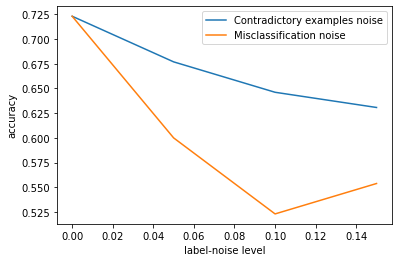

In [21]:
add_class_label_noise(glass_df, X_train, X_test, y_train, y_test)

## 2. tic-tac-toe dataframe

In [16]:
tic_tac_df.shape

(958, 10)

In [17]:
X, y = feature_label_extraction(tic_tac_df)
X_train, X_test, y_train, y_test = test_train_split(X, y)

X_train shape: (670, 9)
y_train shape: (670,)
X_test shape: (288, 9)
y_test shape: (288,)


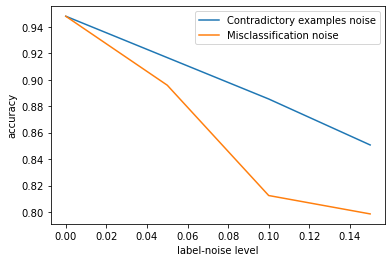

In [18]:
add_class_label_noise(tic_tac_df, X_train, X_test, y_train, y_test)